# Data Preprocessing

Intro to BERT and fine-tuning for sentiment analysis:
- https://machinelearningmastery.com/a-brief-introduction-to-bert/
- https://machinelearningmastery.com/a-complete-introduction-to-using-bert-models/
- https://skimai.com/fine-tuning-bert-for-sentiment-analysis/
- https://mccormickml.com/2019/07/22/BERT-fine-tuning/

## Load the libraries and data

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import ast
import re
import torch

from transformers import BertTokenizer
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv("data/cryptonews.csv")
df.shape

(31037, 7)

In [ ]:
df.sample(10)

,date,sentiment,source,subject,text,title,url
19745,2022-10-11 15:00:00,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CryptoNews,bitcoin,"Get your daily, bite-sized digest of cryptoass...",Crypto News Summary: Coinbase Partners with Go...,https://cryptonews.com/news/crypto-news-summar...
12492,2023-04-05 08:22:00,"{'class': 'positive', 'polarity': 0.4, 'subjec...",CryptoNews,altcoin,"Bitcoin (BTC), potentially the most popular cr...",Bitcoin and Ethereum Price Predictions: Will A...,https://cryptonews.com/news/bitcoin-and-ethere...
17765,2022-11-27 22:01:00,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CryptoPotato,bitcoin,Investors wanting to have a balanced portfolio...,"Investing in Bitcoin Still Makes Sense, Says T...",https://cryptopotato.com/investing-in-bitcoin-...
30638,2022-01-07 13:59:00,"{'class': 'positive', 'polarity': 0.6, 'subjec...",CryptoNews,ethereum,"Contrary to popular belief, BTC and ETH could ...","Bitcoin, Ethereum Could Benefit If Stocks Drop...",https://cryptonews.com/news/bitcoin-ethereum-c...
8018,2023-07-13 08:30:27,"{'class': 'positive', 'polarity': 0.2, 'subjec...",CoinTelegraph,blockchain,The group sent a detailed letter to the U.S. H...,U.S. industry watchdogs oppose draft bill on c...,https://cointelegraph.com/news/crypto-u-s-indu...
15149,2023-02-02 00:42:00,"{'class': 'positive', 'polarity': 0.44, 'subje...",CryptoNews,altcoin,"Despite the challenges of 2022, many analysts ...",Crypto Analysts are Saying These Altcoins Have...,https://cryptonews.com/news/crypto-analysts-ar...
8395,2023-07-06 06:00:00,"{'class': 'positive', 'polarity': 0.01, 'subje...",CryptoNews,altcoin,Chinese state-owned banks are set to join effo...,Chinese Banks Join Beijing's Efforts to Integr...,https://cryptonews.com/news/chinese-banks-join...
28018,2022-03-20 16:00:00,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CryptoPotato,bitcoin,Bitcoin-friendly Portugal is shaping up as a p...,Bitcoin-Friendly Portugal a Perferred Destinat...,https://cryptopotato.com/bitcoin-friendly-port...
9309,2023-06-15 15:54:07,"{'class': 'positive', 'polarity': 0.5, 'subjec...",CoinTelegraph,bitcoin,Bitcoin remains bullish — and arguably more so...,3 Bitcoin price metrics showing 'insane' simil...,https://cointelegraph.com/news/bitcoin-price-m...
19228,2022-10-24 05:27:00,"{'class': 'positive', 'polarity': 0.05, 'subje...",CryptoNews,bitcoin,"On October 24, the BitcoinÂ\xa0price is showin...",Bitcoin and Ethereum Price Prediction \x93 BTC...,https://cryptonews.com/news/bitcoin-price-ethe...


## Transforming data 

### Convert publication timestamp to datetime format

In [25]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['date'].describe()

count                            31035
mean     2023-01-12 21:01:43.553665280
min                2021-10-12 20:00:00
25%         2022-07-10 21:18:26.500000
50%                2023-01-24 17:00:04
75%                2023-07-18 11:34:35
max                2023-12-19 06:40:41
Name: date, dtype: object

### Extract sentiment labels from dictionary string

In [26]:
def extract_sentiment_components(sentiment_str):
    try:
        # Check if the sentiment is already a dictionary
        if isinstance(sentiment_str, dict):
            return {
                'sentiment_class': sentiment_str.get('class'),
                'polarity': sentiment_str.get('polarity'),
                'subjectivity': sentiment_str.get('subjectivity')
            }
            
        # Otherwise, parse it as a string representation of a dictionary
        sentiment_dict = ast.literal_eval(sentiment_str)
        return {
            'sentiment_class': sentiment_dict.get('class'),
            'polarity': sentiment_dict.get('polarity'),
            'subjectivity': sentiment_dict.get('subjectivity')
        }
    except Exception as e:
        print(f"Error parsing sentiment: {sentiment_str}")
        print(f"Error message: {e}")
        return {'sentiment_class': None, 'polarity': None, 'subjectivity': None}

# Apply the function to create new columns
sentiment_components = df['sentiment'].apply(extract_sentiment_components)

# Extract the components into separate columns
df['sentiment_class'] = sentiment_components.apply(lambda x: x['sentiment_class'])
df['polarity'] = sentiment_components.apply(lambda x: x['polarity'])
df['subjectivity'] = sentiment_components.apply(lambda x: x['subjectivity'])

# Optionally drop the original sentiment columns
# df.drop(columns=['sentiment', 'sentiment_dict'], inplace=True, errors='ignore')

df[['sentiment', 'sentiment_class', 'polarity', 'subjectivity']].head()

,sentiment,sentiment_class,polarity,subjectivity
0,"{'class': 'negative', 'polarity': -0.1, 'subje...",negative,-0.10,0.60
1,"{'class': 'neutral', 'polarity': 0.0, 'subject...",neutral,0.00,0.00
2,"{'class': 'positive', 'polarity': 0.05, 'subje...",positive,0.05,0.05
3,"{'class': 'positive', 'polarity': 0.5, 'subjec...",positive,0.50,0.90
4,"{'class': 'neutral', 'polarity': 0.0, 'subject...",neutral,0.00,0.00


### Visualise distribution, polarity and subjectivity of sentiment classes 

In [27]:
sentiment_counts = df['sentiment_class'].value_counts()

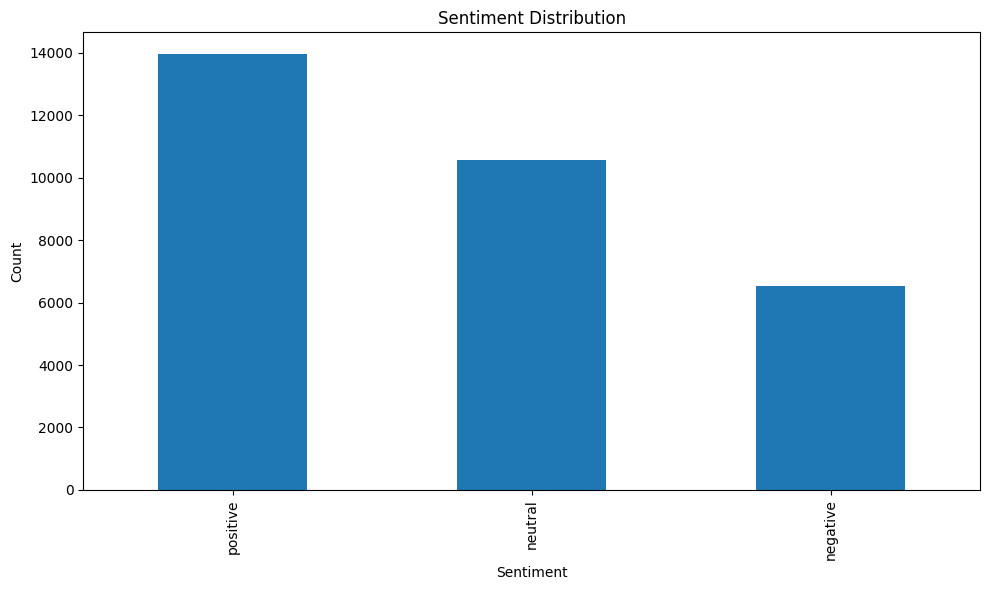

In [28]:
plt.figure(figsize=(10, 6))
sentiment_counts.plot(kind='bar')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

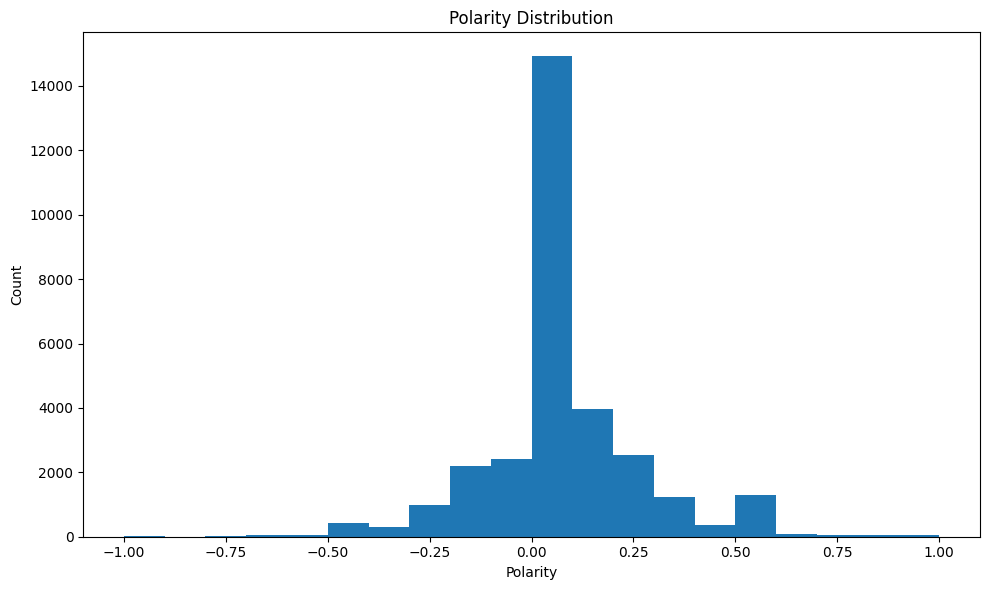

In [29]:
plt.figure(figsize=(10, 6))
plt.hist(df['polarity'], bins=20)
plt.title('Polarity Distribution')
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

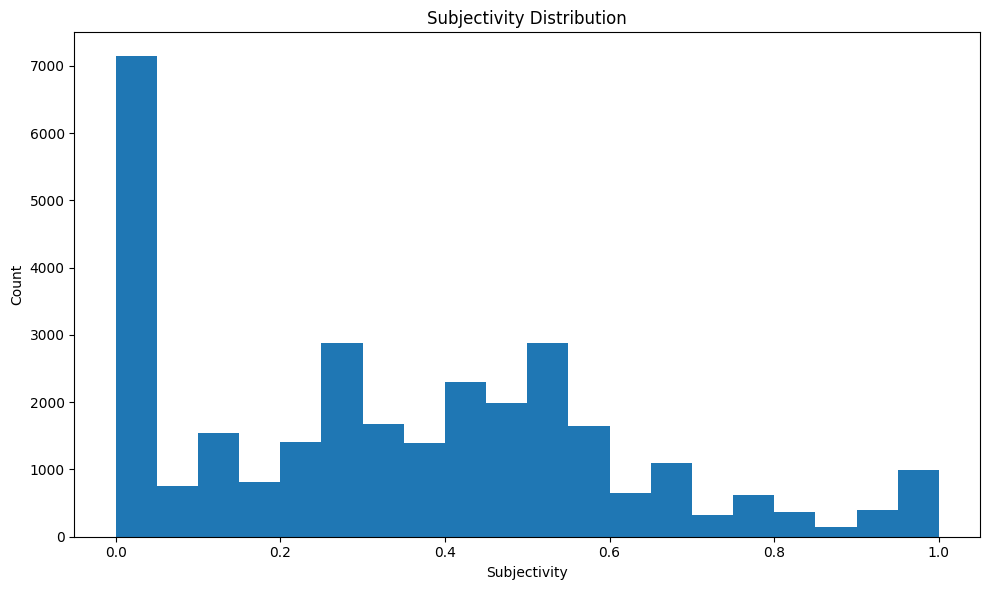

In [30]:
plt.figure(figsize=(10, 6))
plt.hist(df['subjectivity'], bins=20)
plt.title('Subjectivity Distribution')
plt.xlabel('Subjectivity')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

#### Polarity vs subjectivity by sentiment class

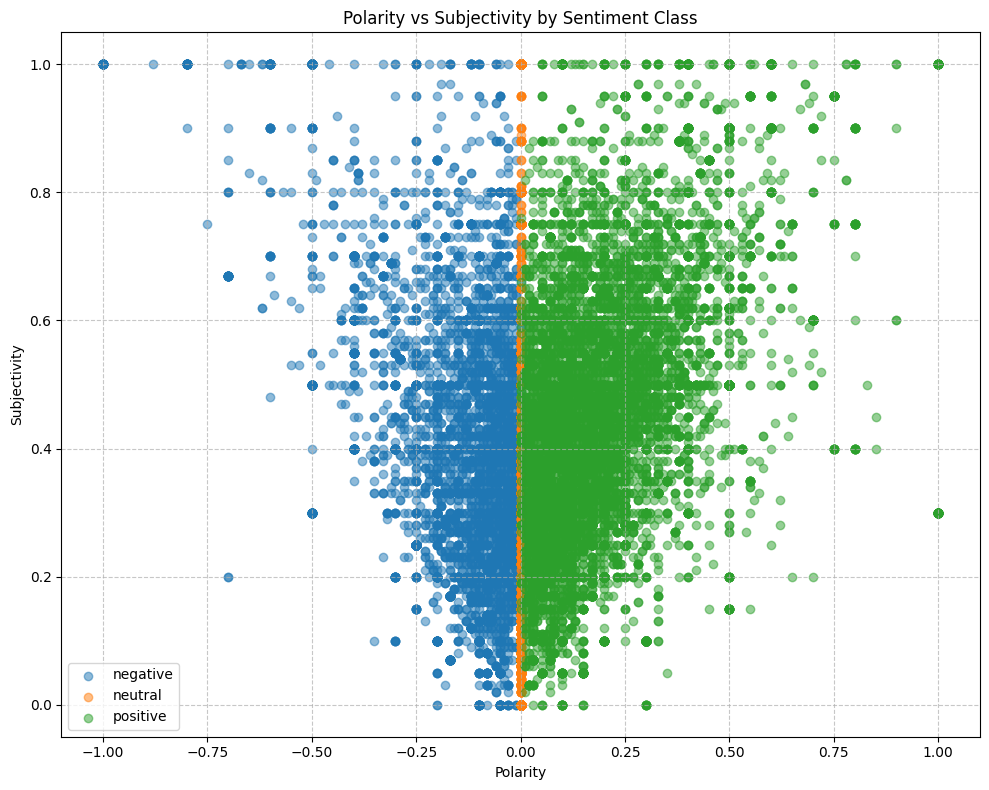

In [31]:
plt.figure(figsize=(10, 8))
for sentiment in df['sentiment_class'].unique():
    subset = df[df['sentiment_class'] == sentiment]
    plt.scatter(subset['polarity'], subset['subjectivity'], label=sentiment, alpha=0.5)
plt.title('Polarity vs Subjectivity by Sentiment Class')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Combine headline and content

In [32]:
df['full_text'] = df['title'].fillna('') + ' ' + df['text'].fillna('')
df.head()

,date,sentiment,source,subject,text,title,url,sentiment_class,polarity,subjectivity,full_text
0,2023-12-19 06:40:41,"{'class': 'negative', 'polarity': -0.1, 'subje...",CryptoNews,altcoin,Grayscale CEO Michael Sonnenshein believes the...,Grayscale CEO Calls for Simultaneous Approval ...,https://cryptonews.comhttps://cryptonews.com/n...,negative,-0.10,0.60,Grayscale CEO Calls for Simultaneous Approval ...
1,2023-12-19 06:03:24,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CryptoNews,blockchain,"In an exclusive interview with CryptoNews, Man...",Indian Government is Actively Collaborating Wi...,https://cryptonews.comhttps://cryptonews.com/n...,neutral,0.00,0.00,Indian Government is Actively Collaborating Wi...
2,2023-12-19 05:55:14,"{'class': 'positive', 'polarity': 0.05, 'subje...",CryptoNews,blockchain,According to the Federal Court ruling on Decem...,Judge Approves Settlement: Binance to Pay $1.5...,https://cryptonews.comhttps://cryptonews.com/n...,positive,0.05,0.05,Judge Approves Settlement: Binance to Pay $1.5...
3,2023-12-19 05:35:26,"{'class': 'positive', 'polarity': 0.5, 'subjec...",CoinTelegraph,blockchain,Some suggest EVM inscriptions are the latest w...,Why a gold rush for inscriptions has broken ha...,https://cointelegraph.com/news/inscriptions-ev...,positive,0.50,0.90,Why a gold rush for inscriptions has broken ha...
4,2023-12-19 05:31:08,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CoinTelegraph,ethereum,A decision by bloXroute Labs to start censorin...,‘Concerning precedent’ — bloXroute Labs' MEV r...,https://cointelegraph.com/news/concerning-prec...,neutral,0.00,0.00,‘Concerning precedent’ — bloXroute Labs' MEV r...


## Data Cleaning

### Remove irrelevant information

In [33]:
def clean_text(text):
    if isinstance(text, str):
        text = re.sub(r'https?://\S+|www\.\S+', '', text) # urls
        text = re.sub(r'<.*?>', '', text) # html tags
        text = re.sub(r'[^\w\s]', ' ', text) # special characters
        text = re.sub(r'\s+', ' ', text) # extra whitespace
        return text.strip()
    return ""

df['clean_text'] = df['full_text'].apply(clean_text)
df.head()

,date,sentiment,source,subject,text,title,url,sentiment_class,polarity,subjectivity,full_text,clean_text
0,2023-12-19 06:40:41,"{'class': 'negative', 'polarity': -0.1, 'subje...",CryptoNews,altcoin,Grayscale CEO Michael Sonnenshein believes the...,Grayscale CEO Calls for Simultaneous Approval ...,https://cryptonews.comhttps://cryptonews.com/n...,negative,-0.10,0.60,Grayscale CEO Calls for Simultaneous Approval ...,Grayscale CEO Calls for Simultaneous Approval ...
1,2023-12-19 06:03:24,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CryptoNews,blockchain,"In an exclusive interview with CryptoNews, Man...",Indian Government is Actively Collaborating Wi...,https://cryptonews.comhttps://cryptonews.com/n...,neutral,0.00,0.00,Indian Government is Actively Collaborating Wi...,Indian Government is Actively Collaborating Wi...
2,2023-12-19 05:55:14,"{'class': 'positive', 'polarity': 0.05, 'subje...",CryptoNews,blockchain,According to the Federal Court ruling on Decem...,Judge Approves Settlement: Binance to Pay $1.5...,https://cryptonews.comhttps://cryptonews.com/n...,positive,0.05,0.05,Judge Approves Settlement: Binance to Pay $1.5...,Judge Approves Settlement Binance to Pay 1 5 B...
3,2023-12-19 05:35:26,"{'class': 'positive', 'polarity': 0.5, 'subjec...",CoinTelegraph,blockchain,Some suggest EVM inscriptions are the latest w...,Why a gold rush for inscriptions has broken ha...,https://cointelegraph.com/news/inscriptions-ev...,positive,0.50,0.90,Why a gold rush for inscriptions has broken ha...,Why a gold rush for inscriptions has broken ha...
4,2023-12-19 05:31:08,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CoinTelegraph,ethereum,A decision by bloXroute Labs to start censorin...,‘Concerning precedent’ — bloXroute Labs' MEV r...,https://cointelegraph.com/news/concerning-prec...,neutral,0.00,0.00,‘Concerning precedent’ — bloXroute Labs' MEV r...,Concerning precedent bloXroute Labs MEV relays...
